In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.data import Dataset
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, BatchNormalization

from einops import rearrange
from sklearn.model_selection import train_test_split

In [14]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [15]:
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)

X_train:  (60000, 28, 28)
X_test:  (10000, 28, 28)


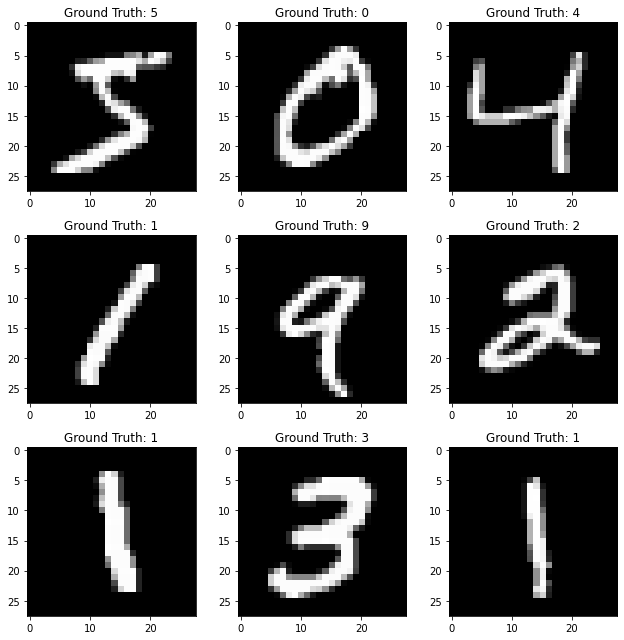

In [16]:
fig = plt.figure(figsize=(9, 9))

for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.tight_layout()
    plt.imshow(X_train[i], cmap="gray", interpolation="none")
    target = y_train[i]
    plt.title("Ground Truth: {}".format(int(target)))

plt.show()

In [17]:
target_size = 10   # 0 ~ 9, 총 9개

### 주의: 흑백 데이터여도 channel 차원을 살려주어야 정상적으로 작동합니다

X_train = rearrange(X_train, "b h w -> b h w 1")
X_test = rearrange(X_test, "b h w -> b h w 1")


datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.20,
    shear_range=15,
    zoom_range=0.10,
    validation_split=0.25,
    horizontal_flip=False)  # randomly flip images

X_train = X_train.astype("float32") / (2 ** 8 - 1)   # 255로 scaling
X_test = X_test.astype("float32") / (2 ** 8 - 1)     # 255로 scaling

datagen.fit(X_train)

y_train = to_categorical(y_train, target_size)       # 타겟을 정수로 변환
y_test = to_categorical(y_test, target_size) 

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [19]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(10000, 28, 28, 1)
(48000, 10)
(12000, 10)
(10000, 10)


In [20]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', padding='same',
                 input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='sigmoid'))
model.add(Dropout(0.25))

model.add(Dense(512, activation='sigmoid'))
model.add(Dropout(0.25))

model.add(Dense(256, activation='sigmoid'))
model.add(Dropout(0.1))

model.add(Dense(10, activation='sigmoid'))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 128)        

In [21]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.1,  
                                                 patience=5,
                                                 min_lr=0.000001,
                                                 verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='model.hdf5',
                                                monitor='val_loss',
                                                save_best_only=True,
                                                save_weights_only=True,
                                                verbose=1)

In [22]:
batch_size = 256
epochs = 100

In [23]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size), epochs = epochs, 
                              validation_data = (X_test, y_test), verbose=1, 
                              steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks = [reduce_lr, checkpoint]) 

Epoch 1/100
187/187 [==============================] - 8s 40ms/step - loss: 0.9099 - accuracy: 0.7023 - val_loss: 0.1375 - val_accuracy: 0.9602

Epoch 00001: val_loss improved from inf to 0.13753, saving model to model.hdf5
Epoch 2/100
187/187 [==============================] - 7s 39ms/step - loss: 0.1749 - accuracy: 0.9497 - val_loss: 0.0545 - val_accuracy: 0.9842

Epoch 00002: val_loss improved from 0.13753 to 0.05453, saving model to model.hdf5
Epoch 3/100
187/187 [==============================] - 7s 39ms/step - loss: 0.1069 - accuracy: 0.9682 - val_loss: 0.0391 - val_accuracy: 0.9888

Epoch 00003: val_loss improved from 0.05453 to 0.03913, saving model to model.hdf5
Epoch 4/100
187/187 [==============================] - 7s 40ms/step - loss: 0.0863 - accuracy: 0.9741 - val_loss: 0.0338 - val_accuracy: 0.9905

Epoch 00004: val_loss improved from 0.03913 to 0.03376, saving model to model.hdf5
Epoch 5/100
187/187 [==============================] - 7s 39ms/step - loss: 0.0677 - accurac

In [24]:
model.load_weights("model.hdf5")
loss, acc = model.evaluate(X_test, y_test)
print("Untrained model, accuracy: {:5.2f}%".format(100*acc))

313/313 [==============================] - 1s 2ms/step - loss: 0.0135 - accuracy: 0.9957
Untrained model, accuracy: 99.57%
